In [1]:
import sys
sys.path.append("/scratch/group/csce435-f24/python-3.10.4/lib/python3.10/site-packages")
sys.path.append("/scratch/group/csce435-f24/thicket")
from glob import glob

import matplotlib.pyplot as plt
import pandas as pd

import thicket as th

pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)

Read all files

In [15]:
#1_trial is a name of a folder containing the cali files, you may create a folder with a different name and replace the folder name here
tk = th.Thicket.from_caliperreader(glob("/scratch/user/weiwu/435-group-proj/Sample_Sort/*.cali"))

(2/2) Creating Thicket: 100%|██████████| 182/182 [00:06<00:00, 28.18it/s]


View Calltree

In [3]:
print(tk.tree(metric_column="Avg time/rank"))

  _____ _     _      _        _   
 |_   _| |__ (_) ___| | _____| |_ 
   | | | '_ \| |/ __| |/ / _ \ __|
   | | | | | | | (__|   <  __/ |_ 
   |_| |_| |_|_|\___|_|\_\___|\__|  v2024.1.0

0.010 MPI_Comm_dup
0.000 MPI_Finalize
0.000 MPI_Finalized
0.000 MPI_Initialized
0.501 main
├─ 0.181 comm
│  ├─ 0.181 comm_large
│  │  ├─ 0.001 MPI_Gatherv
│  │  └─ 0.180 MPI_Scatter
│  └─ 0.000 comm_small
│     └─ 0.000 MPI_Gather
├─ 0.320 comp
│  ├─ 0.320 comp_large
│  │  └─ 0.320 comm
│  │     ├─ 0.029 comm_large
│  │     │  ├─ 0.015 MPI_Alltoall
│  │     │  ├─ 0.013 MPI_Alltoallv
│  │     │  └─ 0.001 MPI_Gather
│  │     └─ 0.291 comm_small
│  │        └─ 0.291 MPI_Bcast
│  └─ 0.000 comp_small
├─ 0.000 correctness_check
└─ 0.002 data_init_runtime

Legend (Metric: Avg time/rank Min: 0.00 Max: 0.50 indices: {'profile': 7201482})
█ 0.45 - 0.50
█ 0.35 - 0.45
█ 0.25 - 0.35
█ 0.15 - 0.25
█ 0.05 - 0.15
█ 0.00 - 0.05

name User code    ◀  Only in left graph    ▶  Only in right graph



Group Performance data by `matrix_size` in the Thicket metadata table.

In [26]:
tk.metadata_column_to_perfdata("num_procs")
tk.metadata_column_to_perfdata("input_size")

tk.dataframe = tk.dataframe.reset_index().set_index(["node", "num_procs", "input_size"]).sort_index()

tk.dataframe.head(10)

profile  \
node                                         num_procs input_size               
{'name': 'MPI_Comm_dup', 'type': 'function'} 2         65536       1009800907   
                                                       65536       1259544429   
                                                       65536       1455625189   
                                                       262144       160966996   
                                                       262144      2889947563   
                                                       262144      2969963664   
                                                       1048576      255418011   
                                                       1048576     1704448285   
                                                       1048576     3089181412   
                                                       4194304     2580257472   

                                                                    nid  \
node                                         num_procs input_size         
{'name': 'MPI_Comm_dup', 'type': 'function'} 2         65536       27.0   
                                                       65536       27.0   
                                                       65536       27.0   
                                                       262144      27.0   
                                                       262144      27.0   
                                                       262144      27.0   
                                                       1048576     27.0   
                                                       1048576     27.0   
                                                       1048576     27.0   
                                                       4194304     27.0   

                                                                    spot.channel  \
node                                         num_procs input_size                  
{'name': 'MPI_Comm_dup', 'type': 'function'} 2         65536       regionprofile   
                                                       65536       regionprofile   
                                                       65536       regionprofile   
                                                       262144      regionprofile   
                                                       262144      regionprofile   
                                                       262144      regionprofile   
                                                       1048576     regionprofile   
                                                       1048576     regionprofile   
                                                       1048576     regionprofile   
                                                       4194304     regionprofile   

                                                                   Min time/rank  \
node                                         num_procs input_size                  
{'name': 'MPI_Comm_dup', 'type': 'function'} 2         65536            0.000090   
                                                       65536            0.000072   
                                                       65536            0.000086   
                                                       262144           0.000082   
                                                       262144           0.000098   
                                                       262144           0.000099   
                                                       1048576          0.000078   
                                                       1048576          0.000106   
                                                       1048576          0.000083   
                                                       4194304          0.000413   

                                                                   Max time/rank  \
node                                         num_procs input_size                  
{'name': '

In [27]:
# Define common variables
processes = [2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]
input_sizes = [2**16, 2**18, 2**20, 2**22, 2**24, 2**26, 2**28]

In [80]:
# Change font size for all plots
plt.rcParams.update({"font.size": 12})

In [29]:
def plot_pandas(df, title, xlabel, ylabel):
    plot = df.plot(kind="line", 
        marker='o', 
        title=title, 
        xlabel=xlabel,
        ylabel=ylabel, 
        figsize=(15,7)
    )
    return plot

In [30]:
def plot_mpl(df, title, xlabel, ylabel):
    fig = plt.figure(figsize=(15,7))
    ax = fig.add_subplot(1, 1, 1)
    ax.plot(
        df,
        marker='o',
    )
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.legend(matrix_sizes)
    plt.xscale("log", base=2)
    plt.xticks(threads)
    ax.set_xticklabels(threads)
    plt.show()
    return fig, ax

In [31]:
tk.dataframe.keys()

Index(['profile', 'nid', 'spot.channel', 'Min time/rank', 'Max time/rank',
       'Avg time/rank', 'Total time', 'Variance time/rank', 'Calls/rank (min)',
       'Calls/rank (avg)', 'Calls/rank (max)', 'Calls/rank (total)',
       'Min time/rank (exc)', 'Max time/rank (exc)', 'Avg time/rank (exc)',
       'Total time (exc)', 'name'],
      dtype='object')

In [32]:
tk.dataframe.head()

profile  \
node                                         num_procs input_size               
{'name': 'MPI_Comm_dup', 'type': 'function'} 2         65536       1009800907   
                                                       65536       1259544429   
                                                       65536       1455625189   
                                                       262144       160966996   
                                                       262144      2889947563   

                                                                    nid  \
node                                         num_procs input_size         
{'name': 'MPI_Comm_dup', 'type': 'function'} 2         65536       27.0   
                                                       65536       27.0   
                                                       65536       27.0   
                                                       262144      27.0   
                                                       262144      27.0   

                                                                    spot.channel  \
node                                         num_procs input_size                  
{'name': 'MPI_Comm_dup', 'type': 'function'} 2         65536       regionprofile   
                                                       65536       regionprofile   
                                                       65536       regionprofile   
                                                       262144      regionprofile   
                                                       262144      regionprofile   

                                                                   Min time/rank  \
node                                         num_procs input_size                  
{'name': 'MPI_Comm_dup', 'type': 'function'} 2         65536            0.000090   
                                                       65536            0.000072   
                                                       65536            0.000086   
                                                       262144           0.000082   
                                                       262144           0.000098   

                                                                   Max time/rank  \
node                                         num_procs input_size                  
{'name': 'MPI_Comm_dup', 'type': 'function'} 2         65536            0.000287   
                                                       65536            0.000272   
                                                       65536            0.000286   
                                                       262144           0.000855   
                                                       262144           0.001066   

                                                                   Avg time/rank  \
node                                         num_procs input_size                  
{'name': 'MPI_Comm_dup', 'type': 'function'} 2         65536            0.000188   
                                                       65536            0.000172   
                                                       65536            0.000186   
                                                       262144           0.000469   
                                                       262144           0.000582   

                                                                   Total time  \
node                                         num_procs input_size               
{'name': 'MPI_Comm_dup', 'type': 'function'} 2         65536         0.000376   
                                                       65536         0.000344   
                                                       65536         0.000372   
                                                       262144        0.000937   
                                                       262144        0.001164   

                                                    

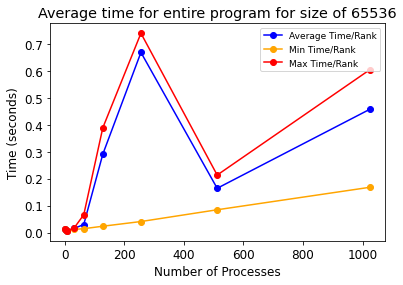

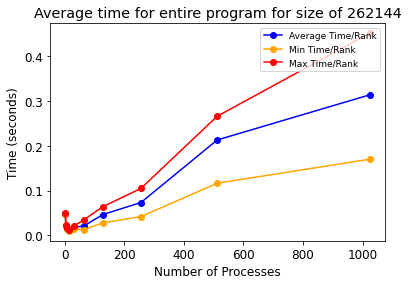

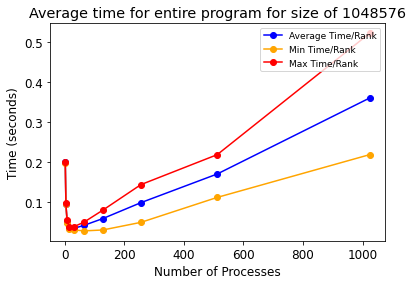

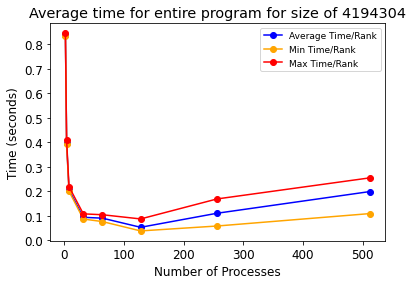

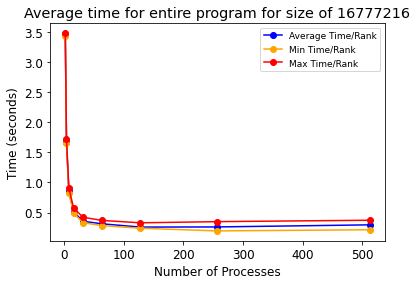

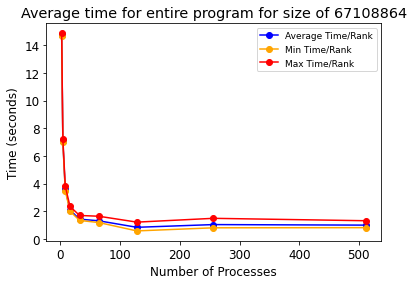

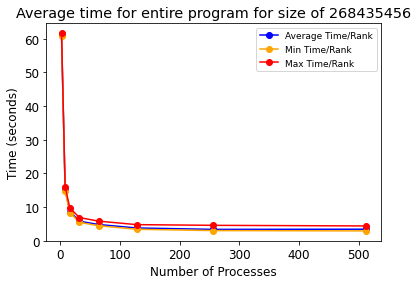

<Figure size 432x288 with 0 Axes>

In [87]:
for node in tk.graph.traverse():
    for m_size in input_sizes:
        if node.frame["name"] in ("main"):
            new_df = tk.dataframe.loc[node]
            x_vals_processes = []
            y_vals_avg = []
            y_vals_min = []
            y_vals_max = []
            data = new_df.loc[(slice(None), m_size), "Avg time/rank"]
            data1 = new_df.loc[(slice(None), m_size), "Min time/rank"]
            data2 = new_df.loc[(slice(None), m_size), "Max time/rank"]
            for process in processes:
                try:
                    temp = data[(process, m_size)]
                    avg = 0
                    counter = 0
                    for val in temp:
                        avg += val
                        counter += 1
                    avg = avg/counter
                    y_vals_avg.append(avg)
                    x_vals_processes.append(process)
                except:
                    pass
            for process in processes:
                try:
                    temp = data1[(process, m_size)]
                    avg = 0
                    counter = 0
                    for val in temp:
                        avg += val
                        counter += 1
                    avg = avg/counter
                    y_vals_min.append(avg)
                except:
                    pass
            for process in processes:
                try:
                    temp = data2[(process, m_size)]
                    avg = 0
                    counter = 0
                    for val in temp:
                        avg += val
                        counter += 1
                    avg = avg/counter
                    y_vals_max.append(avg)
                except:
                    pass
            plt.plot(x_vals_processes, y_vals_avg, marker='o', color='blue', label="Average Time/Rank")
            plt.plot(x_vals_processes, y_vals_min, marker='o', color='orange', label="Min Time/Rank")
            plt.plot(x_vals_processes, y_vals_max, marker='o', color='red', label="Max Time/Rank")
            plt.xlabel("Number of Processes")
            plt.ylabel('Time (seconds)')
            plt.legend(loc=1, prop={'size': 9})
            plt.title(f'Average time for entire program for size of {m_size}')
            plt.savefig(f'./plots/sample_sort_main_{m_size}')
            plt.show()
            plt.clf()
        

In [ ]:
for node in tk.graph.traverse():
    for m_size in input_sizes:
        if node.frame["name"] in ("main"):
            new_df = tk.dataframe.loc[node]
            x_vals_processes = []
            y_vals_avg = []
            data = new_df.loc[(slice(None), m_size), "Avg time/rank"]
            for process in processes:
                try:
                    temp = data[(process, m_size)]
                    avg = 0
                    counter = 0
                    for val in temp:
                        avg += val
                        counter += 1
                    avg = avg/counter
                    y_vals_avg.append(avg)
                    x_vals_processes.append(process)
                except:
                    pass